<a href="https://colab.research.google.com/github/kennyg37/sound_clustering/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [3]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

**Loading dataset from drive**


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Load and extract features from sound files
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return np.mean(mel_spec_db, axis=1)

# Load dataset
data_path =  "/content/drive/MyDrive/unlabelled_sounds/"
files = [f for f in os.listdir(data_path) if f.endswith('.wav')]
features = [extract_features(os.path.join(data_path, f)) for f in files]
features_array = np.array(features)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1493
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1953
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1410
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1446
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1915
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1673
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py

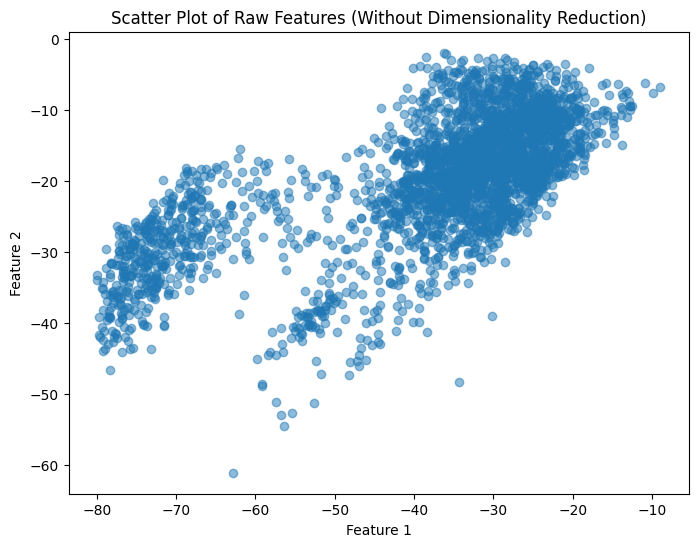

In [6]:
# Attempt visualization without dimensionality reduction
plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1], alpha=0.5)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

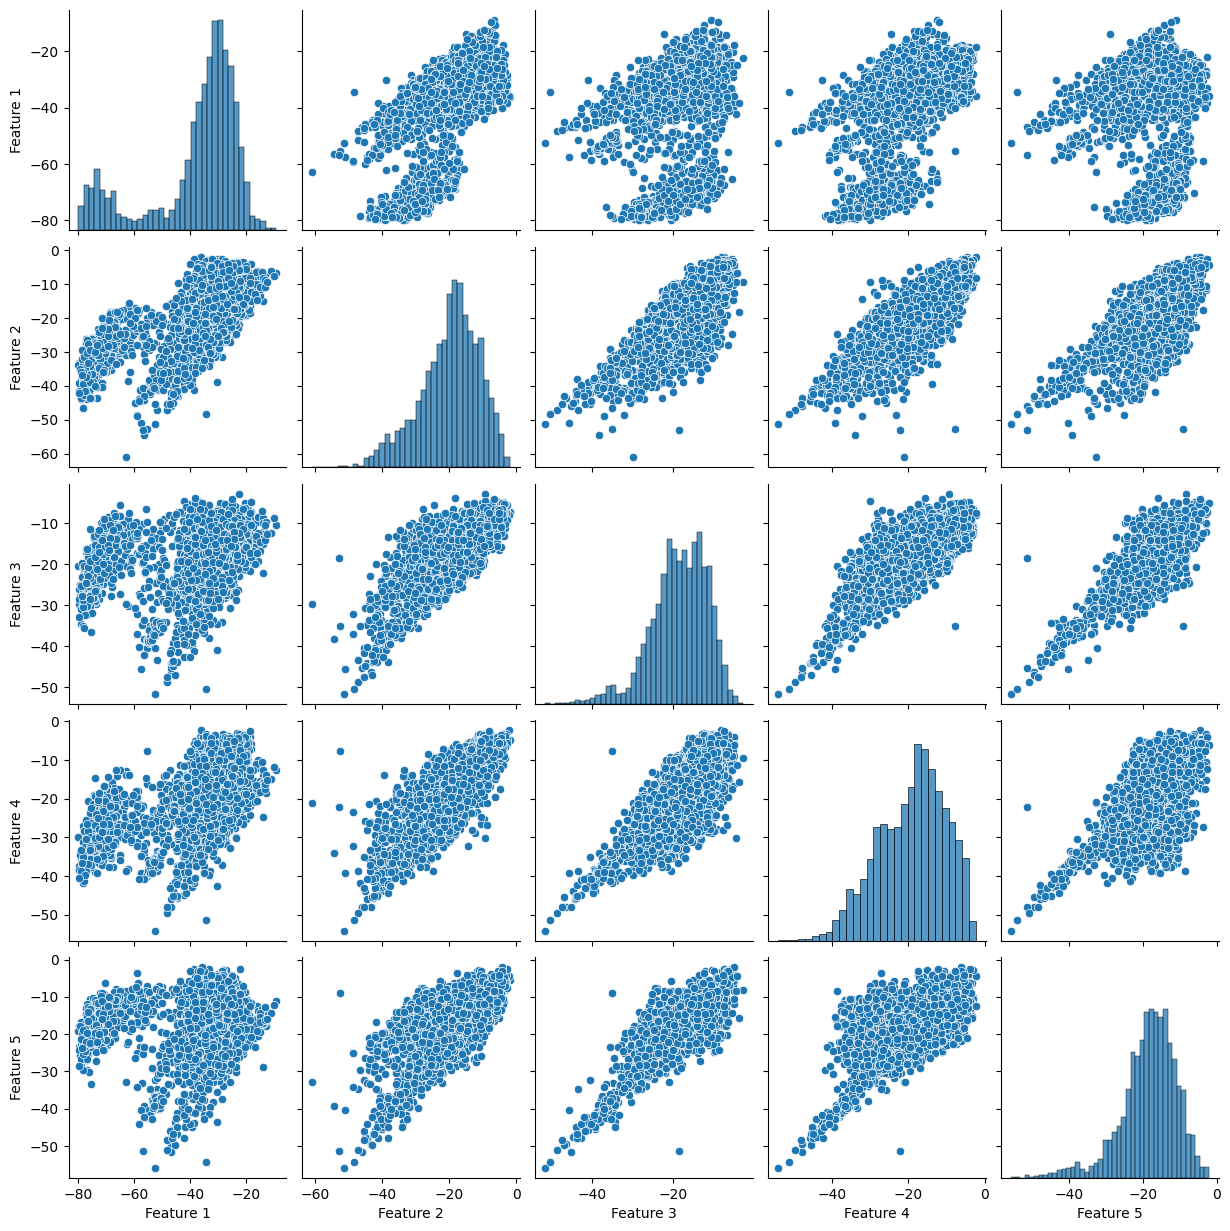

In [7]:
# Pair plot (using first 5 features)
df = pd.DataFrame(features_array[:, :5], columns=[f'Feature {i+1}' for i in range(5)])
sns.pairplot(df)
plt.show()

### Why is dimensionality reduction important?
High-dimensional data is difficult to visualize and interpret directly. In our case, with 40 extracted features,
direct scatter plots and pair plots become cluttered, making it hard to discern patterns or natural clusters.
Dimensionality reduction techniques like PCA and t-SNE help project the data into lower dimensions while preserving
important relationships, improving visualization and clustering accuracy.

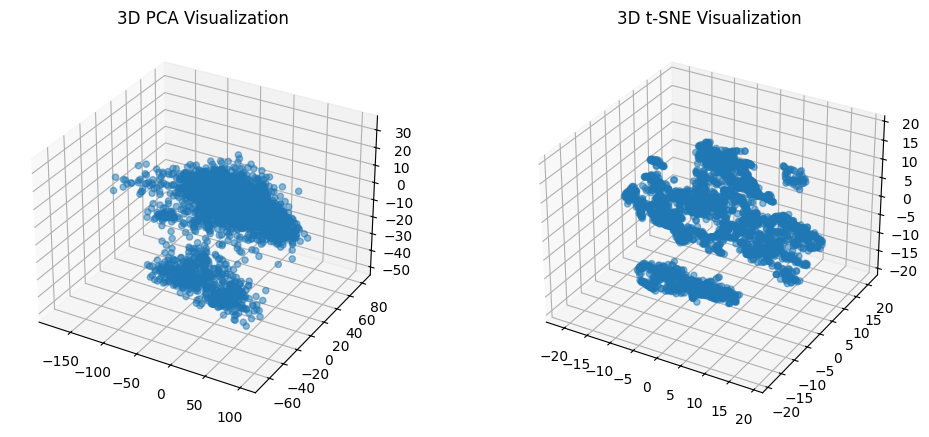

In [8]:
# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_array)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_array)

# 3D Visualization of PCA and t-SNE
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.5)
ax1.set_title("3D PCA Visualization")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.5)
ax2.set_title("3D t-SNE Visualization")
plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?
t-SNE generally provides better separability in high-dimensional clustering since it preserves local structures.
PCA, however, optimizes for variance retention, which might not always align with cluster separability.
Based on our plots, t-SNE likely shows more distinct clusters.

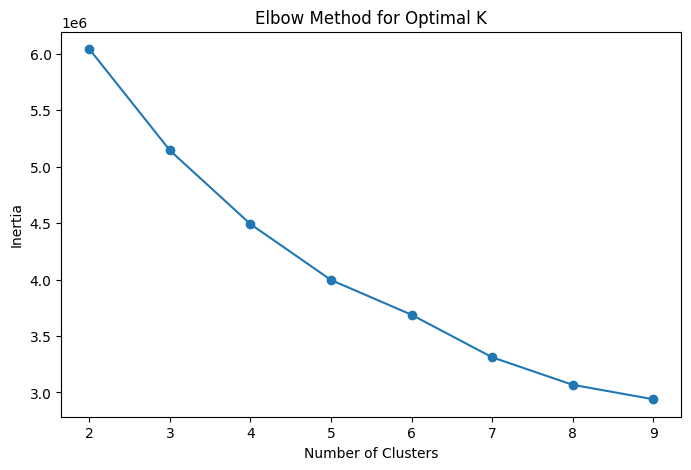

In [9]:
# Optimize number of clusters using the elbow method
inertia = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_array)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

In [10]:

# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_array)



In [11]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_array, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_array, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.2047, Davies-Bouldin Index: 1.4772
DBSCAN failed to form meaningful clusters.


### Discuss the results (max 5 lines)
K-Means performed better in terms of compactness (higher silhouette score of 0.2047) and structure (lower Davies-Bouldin index).
DBSCAN struggled to form clusters, likely due to parameter sensitivity or overlapping data points.
The elbow method helped optimize K-Means, while DBSCAN required careful tuning of eps and min_samples.

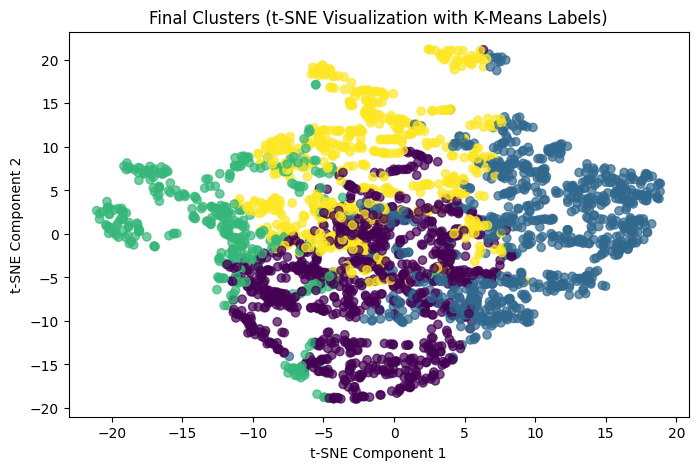

In [12]:
# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()

### **Final Analysis**  
Dimensionality reduction made it easier to visualize the data and helped reveal hidden patterns that were difficult to see in the original high-dimensional space. t-SNE provided clearer separation between clusters compared to PCA, making it more useful for identifying distinct groups. K-Means performed better because it effectively grouped similar data points, while DBSCAN struggled due to overlapping features and sensitivity to parameter choices. This shows that different clustering methods work better depending on the dataset structure. In real-world applications, fine-tuning parameters and choosing the right clustering method are essential for getting meaningful results.